# Modelling using SVM

In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [2]:
import pandas as pd

df = pd.read_csv('../data/preprocessed/review_tiktok_dataset_sentiment_indobertweet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   at                100000 non-null  object 
 1   reviewId          100000 non-null  object 
 2   userName          100000 non-null  object 
 3   score             100000 non-null  int64  
 4   content           100000 non-null  object 
 5   cleaning          100000 non-null  object 
 6   case_folding      100000 non-null  object 
 7   no_elongation     100000 non-null  object 
 8   formalization     99773 non-null   object 
 9   tokenized         100000 non-null  object 
 10  stopword_removal  100000 non-null  object 
 11  stemming          100000 non-null  object 
 12  sentiment         100000 non-null  object 
 13  confident_score   100000 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 10.7+ MB


In [3]:
df_filtered = df[df['confident_score'] >= 0.9]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78304 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   at                78304 non-null  object 
 1   reviewId          78304 non-null  object 
 2   userName          78304 non-null  object 
 3   score             78304 non-null  int64  
 4   content           78304 non-null  object 
 5   cleaning          78304 non-null  object 
 6   case_folding      78304 non-null  object 
 7   no_elongation     78304 non-null  object 
 8   formalization     78295 non-null  object 
 9   tokenized         78304 non-null  object 
 10  stopword_removal  78304 non-null  object 
 11  stemming          78304 non-null  object 
 12  sentiment         78304 non-null  object 
 13  confident_score   78304 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 9.0+ MB


In [4]:
df_filtered.isna().sum()

at                  0
reviewId            0
userName            0
score               0
content             0
cleaning            0
case_folding        0
no_elongation       0
formalization       9
tokenized           0
stopword_removal    0
stemming            0
sentiment           0
confident_score     0
dtype: int64

In [5]:
df_filtered = df_filtered.dropna(subset=['formalization']).reset_index(drop=True)

In [6]:
df_filtered.isna().sum()

at                  0
reviewId            0
userName            0
score               0
content             0
cleaning            0
case_folding        0
no_elongation       0
formalization       0
tokenized           0
stopword_removal    0
stemming            0
sentiment           0
confident_score     0
dtype: int64

## Sentimnet Distribution

In [7]:
df_filtered['sentiment'].value_counts()

sentiment
Negative    58747
Positive    10881
Neutral      8667
Name: count, dtype: int64

## Data Split

In [8]:
from sklearn.model_selection import train_test_split

X = df_filtered['stemming']
y = df_filtered['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})


## Resampling

In [9]:
train_df['label'].value_counts()

label
Negative    46998
Positive     8705
Neutral      6933
Name: count, dtype: int64

In [10]:
from sklearn.utils import resample

# Pisahkan tiap kelas
# df_negative = train_df[train_df['label'] == 'Negative'].sample(n=6933, random_state=42)
# df_positive = train_df[train_df['label'] == 'Positive'].sample(n=6933, random_state=42)
# df_neutral = train_df[train_df['label'] == 'Neutral']

df_negative = train_df[train_df['label'] == 'Negative']

df_positive = resample(
    train_df[train_df['label'] == 'Positive'],
    replace=True,
    n_samples=46998,  
    random_state=42
)

df_neutral = resample(
    train_df[train_df['label'] == 'Neutral'],
    replace=True,
    n_samples=46998,
    random_state=42
)

# Gabungkan dan acak
train_balanced = pd.concat([df_negative, df_positive, df_neutral]).sample(frac=1, random_state=42).reset_index(drop=True)


In [11]:
train_balanced['label'].value_counts()

label
Neutral     46998
Negative    46998
Positive    46998
Name: count, dtype: int64

## TF-IDF Vectorization & Modelling


📌 Evaluating max_features=70000 ...
Accuracy       : 0.9270
F1-Macro       : 0.8532
F1-Weighted    : 0.9262

Classification Report:
              precision    recall  f1-score
Negative       0.964361  0.967316  0.965837
Neutral        0.730365  0.681084  0.704864
Positive       0.872840  0.905331  0.888789
accuracy       0.927007  0.927007  0.927007
macro avg      0.855855  0.851244  0.853163
weighted avg   0.925732  0.927007  0.926231


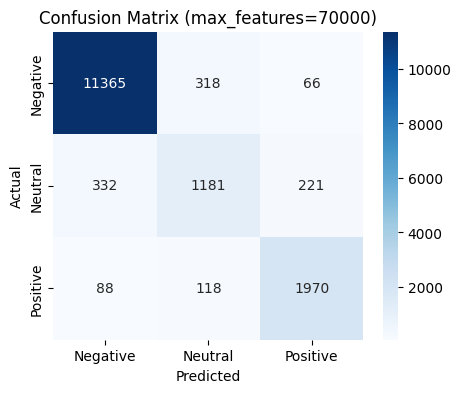


📌 Evaluating max_features=80000 ...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

max_features_list = [70000, 80000]
results = []

for mf in max_features_list:
    print(f"\n📌 Evaluating max_features={mf} ...")
    
    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=mf, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(train_balanced['text'])
    X_test_vec = vectorizer.transform(test_df['text'])

    # SVM model
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train_vec, train_balanced['label'])

    # Predict
    y_pred = model.predict(X_test_vec)
    y_true = test_df['label']

    # Evaluation Metrics
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, output_dict=True, digits=4)
    cm = confusion_matrix(y_true, y_pred, labels=["Negative", "Neutral", "Positive"])

    # Save results
    results.append({
        'max_features': mf,
        'accuracy': acc,
        'f1_macro': report_dict['macro avg']['f1-score'],
        'report': report_dict,
        'confusion_matrix': cm
    })

    # Print Report
    print(f"Accuracy       : {acc:.4f}")
    print(f"F1-Macro       : {report_dict['macro avg']['f1-score']:.4f}")
    print(f"F1-Weighted    : {report_dict['weighted avg']['f1-score']:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(report_dict).transpose()[['precision', 'recall', 'f1-score']])

    # Confusion Matrix (visual)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.title(f'Confusion Matrix (max_features={mf})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
